# PHẦN 5: PHÂN TÍCH PHÂN CỤM & PHÂN ĐOẠN SINH VIÊN
5.1. Chuẩn bị & chuẩn hóa dữ liệu

Mục tiêu

Đảm bảo dữ liệu phù hợp với K-means

Tất cả biến là số, không thiếu, cùng thang đo

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings("ignore")

plt.style.use("ggplot")
sns.set_palette("husl")

# ===== UPLOAD FILE TỪ MÁY (GOOGLE COLAB) =====
from google.colab import files

uploaded = files.upload()   # Chọn file Excel từ máy

# Lấy tên file vừa upload
file_name = list(uploaded.keys())[0]

# Load dữ liệu
df = pd.read_excel(file_name)

print("Dữ liệu ban đầu:")
print(df.shape)
display(df.head())

Saving database_clean.xlsx to database_clean (1).xlsx
Dữ liệu ban đầu:
(1944, 22)


,Year,Gender,Policy_Stu,Minority_Stu,Poor_Stu,Father_Edu,Mother_Edu,Father_Occupation,Mother_Occupation,Time_Friends,...,GPA,Adapt_Learning_Uni,Study_Methods,SupportOf_Uni,SupportOf_Lec,Facilitie_Uni,Quality_Lecturer,TrainingCurriculum,Competitive_Class,InfuenceF_Friends
0,5,2,2,2,2,4,4,2,3,2,...,4,4,4,3,4,4,4,4,3,3
1,5,1,2,2,2,3,3,2,4,1,...,3,3,3,3,4,4,3,3,3,4
2,5,2,2,2,2,4,4,1,2,1,...,4,4,4,4,4,3,4,4,4,4
3,5,2,2,2,2,5,4,1,1,2,...,4,4,4,5,5,5,5,4,4,4
4,5,1,1,2,2,2,3,3,3,1,...,4,5,5,5,5,5,5,5,4,5


Kiểm tra mã hóa & kiểu dữ liệu

In [27]:
non_numeric_cols = df.select_dtypes(exclude=[np.number]).columns.tolist()

if len(non_numeric_cols) > 0:
    print("Các cột KHÔNG phải số (sẽ loại khỏi chuẩn hóa/K-means):", non_numeric_cols)
    df_num = df.drop(columns=non_numeric_cols).copy()
else:
    print("Tất cả các biến đều là số (numeric).")
    df_num = df.copy()

print("Numeric shape:", df_num.shape)

if df_num.shape[1] == 0:
    raise ValueError("Không có cột số nào để chuẩn hóa. K-means cần dữ liệu số.")

Tất cả các biến đều là số (numeric).
Numeric shape: (1944, 22)


Kiểm tra giá trị bị thiếu

In [28]:
missing_by_col = df_num.isna().sum().sort_values(ascending=False)
total_missing = int(missing_by_col.sum())

print("\nTổng số missing:", total_missing)
if total_missing > 0:
    print("Top cột có missing:")
    display(missing_by_col.head(10))
    df_num = df_num.fillna(df_num.median())
    print("Đã xử lý missing bằng MEDIAN.")
else:
    print("Không có missing.")


Tổng số missing: 0
Không có missing.


Kiểm tra outlier theo IQR

In [29]:
Q1 = df_num.quantile(0.25)
Q3 = df_num.quantile(0.75)
IQR = Q3 - Q1
lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR

outlier_mask = (df_num < lower) | (df_num > upper)
outlier_count = int(outlier_mask.sum().sum())

print("\nTổng số outlier theo IQR (toàn bảng):", outlier_count)

CLIP_OUTLIERS = False  # <-- đổi True nếu bạn muốn clip outlier trước khi scale
if CLIP_OUTLIERS:
    df_num = df_num.clip(lower=lower, upper=upper, axis=1)
    print("Đã clip outlier theo IQR.")


Tổng số outlier theo IQR (toàn bảng): 1136


Chuẩn hóa dữ liệu bằng StandardScaler (22 biến)

In [30]:
scaler = StandardScaler()
X = scaler.fit_transform(df_num)  # numpy array (n_samples, n_features)

df_scaled = pd.DataFrame(X, columns=df_num.columns)

print("\nĐã chuẩn hóa dữ liệu (StandardScaler).")
print("Mean trung bình (xấp xỉ 0):", round(df_scaled.mean().mean(), 4))
print("Std trung bình (xấp xỉ 1):", round(df_scaled.std(ddof=0).mean(), 4))
display(df_scaled.head())


Đã chuẩn hóa dữ liệu (StandardScaler).
Mean trung bình (xấp xỉ 0): 0.0
Std trung bình (xấp xỉ 1): 1.0


,Year,Gender,Policy_Stu,Minority_Stu,Poor_Stu,Father_Edu,Mother_Edu,Father_Occupation,Mother_Occupation,Time_Friends,...,GPA,Adapt_Learning_Uni,Study_Methods,SupportOf_Uni,SupportOf_Lec,Facilitie_Uni,Quality_Lecturer,TrainingCurriculum,Competitive_Class,InfuenceF_Friends
0,0.577206,0.354473,0.759370,0.264377,0.212512,0.225106,0.283977,-0.459317,0.457636,-0.259736,...,0.917838,0.561097,0.406536,-1.006348,-0.207256,-0.064787,-0.400171,-0.139131,-1.061911,-0.941052
1,0.577206,-2.821086,0.759370,0.264377,0.212512,-0.514094,-0.466093,-0.459317,1.402058,-1.210632,...,-0.379818,-0.480711,-0.670176,-1.006348,-0.207256,-0.064787,-1.611905,-1.304954,-1.061911,0.196638
2,0.577206,0.354473,0.759370,0.264377,0.212512,0.225106,0.283977,-1.382700,-0.486785,-1.210632,...,0.917838,0.561097,0.406536,0.006251,-0.207256,-1.056480,-0.400171,-0.139131,0.071105,0.196638
3,0.577206,0.354473,0.759370,0.264377,0.212512,0.964307,0.283977,-1.382700,-1.431207,-0.259736,...,0.917838,0.561097,0.406536,1.018850,0.943903,0.926907,0.811562,-0.139131,0.071105,0.196638
4,0.577206,-2.821086,-1.316882,0.264377,0.212512,-1.253295,-0.466093,0.464067,0.457636,-1.210632,...,0.917838,1.602904,1.483248,1.018850,0.943903,0.926907,0.811562,1.026692,0.071105,1.334328


Kiểm tra ma trận tương quan (đa cộng tuyến)

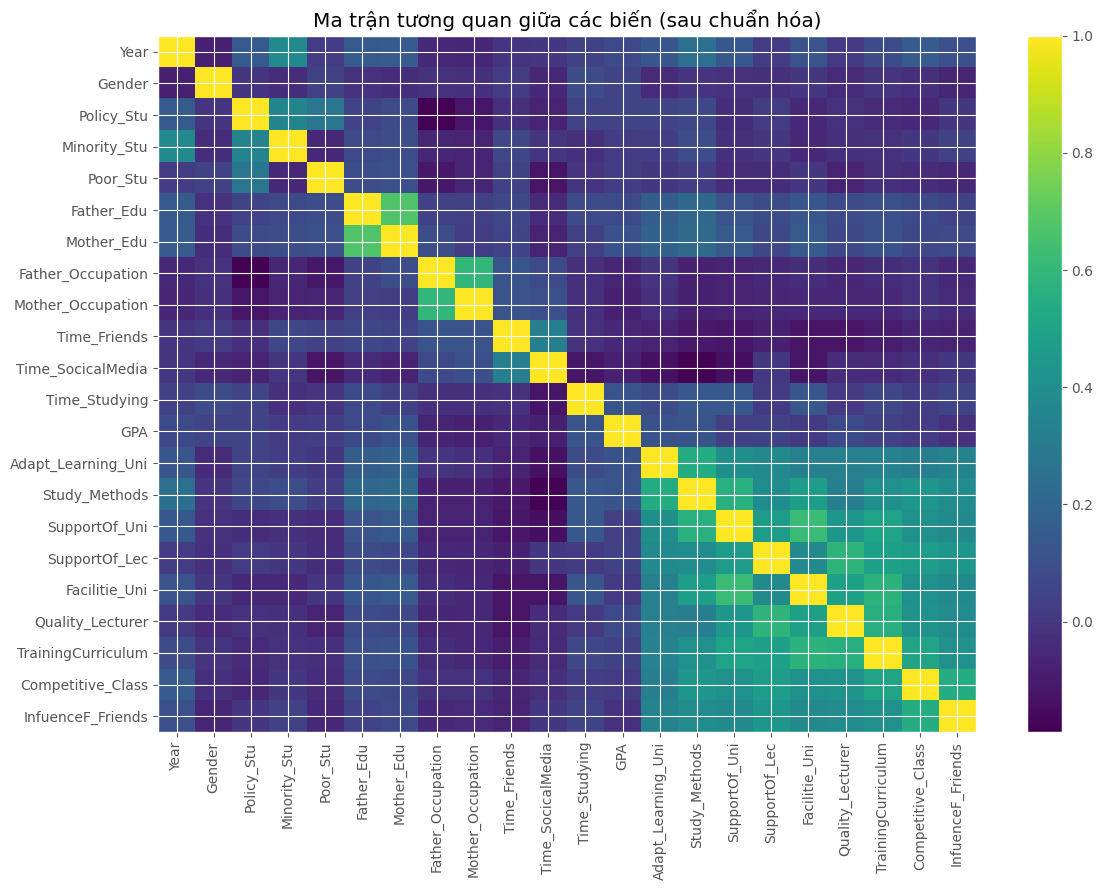

In [31]:
corr = df_scaled.corr()

plt.figure(figsize=(12, 9))
plt.imshow(corr, aspect="auto")
plt.colorbar()
plt.title("Ma trận tương quan giữa các biến (sau chuẩn hóa)")
plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
plt.yticks(range(len(corr.columns)), corr.columns)
plt.tight_layout()
plt.show()

Output để dùng cho phần sau

In [32]:
print("\nOutput ready for next steps:")
print("- df_num   :", df_num.shape, "(numeric, đã xử lý missing/outlier nếu bật)")
print("- df_scaled:", df_scaled.shape, "(numeric, đã chuẩn hóa)")
print("- X        :", X.shape, "(numpy dùng cho KMeans)")


Output ready for next steps:
- df_num   : (1944, 22) (numeric, đã xử lý missing/outlier nếu bật)
- df_scaled: (1944, 22) (numeric, đã chuẩn hóa)
- X        : (1944, 22) (numpy dùng cho KMeans)


5.2. Xác định K tối ưu (Elbow + Silhouette)

Mục tiêu

Xác định số cụm hợp lý nhất cho dữ liệu sinh viên

In [33]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ---- dùng X cho đúng chuẩn (kmeans + silhouette đều nhận X) ----
K_range = range(2, 11)
inertias = []
sil_scores = []

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X)

    inertias.append(kmeans.inertia_)
    sil_scores.append(silhouette_score(X, labels))

# Tạo bảng kết quả
k_table = pd.DataFrame({
    "K": list(K_range),
    "Inertia(SSE)": inertias,
    "Silhouette": sil_scores
})

print("Bảng Elbow + Silhouette:")
display(k_table)

Bảng Elbow + Silhouette:


,K,Inertia(SSE),Silhouette
0,2,36870.373278,0.142392
1,3,34512.735012,0.115485
2,4,32498.372049,0.103177
3,5,30453.623369,0.113384
4,6,29112.574359,0.112151
5,7,27953.195668,0.106584
6,8,27038.815954,0.102527
7,9,26190.830530,0.105432
8,10,25635.976413,0.106342


Biểu đồ Elbow & Silhouette

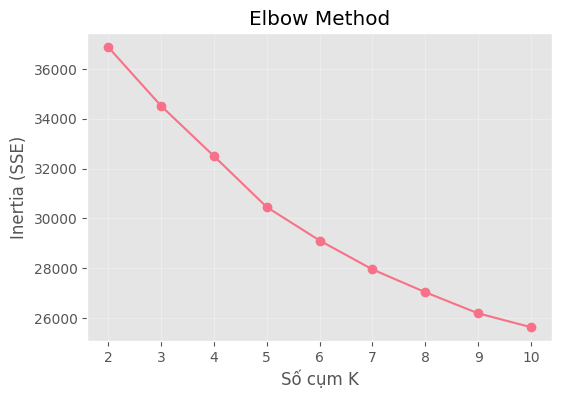

In [34]:
# -----------------------------
# Vẽ Elbow (Inertia)
# -----------------------------
plt.figure(figsize=(6, 4))
plt.plot(list(K_range), inertias, marker="o")
plt.xlabel("Số cụm K")
plt.ylabel("Inertia (SSE)")
plt.title("Elbow Method")
plt.grid(True, alpha=0.3)
plt.show()

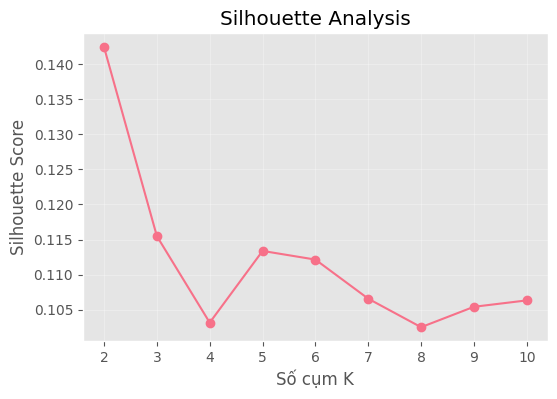

In [35]:
# -----------------------------
# Vẽ Silhouette
# -----------------------------
plt.figure(figsize=(6, 4))
plt.plot(list(K_range), sil_scores, marker="o")
plt.xlabel("Số cụm K")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Analysis")
plt.grid(True, alpha=0.3)
plt.show()

Lựa chọn K tối ưu

In [36]:
# ============================================================
# TỰ CHỌN K (logic hơn lấy max silhouette)
# Score = Silhouette - penalty*(K-2)
# penalty nhỏ giúp tránh chọn K quá lớn khi silhouette chỉ nhỉnh hơn chút
# ============================================================
penalty = 0.02  # 0.01–0.03 (0.02 thường ổn)
k_table["Score"] = k_table["Silhouette"] - penalty * (k_table["K"] - 2)

optimal_k = int(k_table.loc[k_table["Score"].idxmax(), "K"])

print("=" * 60)
print(f"Số cụm tối ưu (tự chọn): K = {optimal_k}")
print("Lý do: cân bằng Silhouette cao và tránh K quá lớn (penalty).")
print("=" * 60)

print("Top lựa chọn theo Score:")
display(k_table.sort_values("Score", ascending=False))

Số cụm tối ưu (tự chọn): K = 2
Lý do: cân bằng Silhouette cao và tránh K quá lớn (penalty).
Top lựa chọn theo Score:


,K,Inertia(SSE),Silhouette,Score
0,2,36870.373278,0.142392,0.142392
1,3,34512.735012,0.115485,0.095485
2,4,32498.372049,0.103177,0.063177
3,5,30453.623369,0.113384,0.053384
4,6,29112.574359,0.112151,0.032151
5,7,27953.195668,0.106584,0.006584
6,8,27038.815954,0.102527,-0.017473
7,9,26190.830530,0.105432,-0.034568
8,10,25635.976413,0.106342,-0.053658


5.3. Phân cụm bằng thuật toán K-means

In [37]:
from sklearn.cluster import KMeans

kmeans_final = KMeans(
    n_clusters=optimal_k,
    random_state=42,
    n_init=20
)

# Thực hiện phân cụm
clusters = kmeans_final.fit_predict(X)

print("Đã hoàn thành phân cụm K-means")
print("Số cụm K =", optimal_k)

Đã hoàn thành phân cụm K-means
Số cụm K = 2


5.4. Phân tích và mô tả cụm

Gán nhãn cụm vào dữ liệu gốc

In [38]:
import pandas as pd

# -----------------------------
# 5.4.1 Gắn nhãn cụm vào dữ liệu gốc
# -----------------------------
df_result = df.copy()
df_result["Cluster"] = clusters

print("5.4.1 Đã gắn nhãn cụm (Cluster) vào dữ liệu gốc.")
display(df_result.head())

# -----------------------------
# 5.4.2 Thống kê số lượng sinh viên trong mỗi cụm
# -----------------------------
cluster_counts = df_result["Cluster"].value_counts().sort_index()
cluster_percent = (cluster_counts / len(df_result) * 100).round(2)

cluster_summary = pd.DataFrame({
    "Count": cluster_counts,
    "Percent(%)": cluster_percent
})

print("\n5.4.2 Số lượng sinh viên trong mỗi cụm:")
display(cluster_summary)

# -----------------------------
# 5.4.3 Tính tâm cụm (Centroids)
# - cluster_centers_ nằm trong không gian chuẩn hóa (X)
# - vì vậy tên cột nên khớp với df_num.columns (dữ liệu numeric trước chuẩn hóa)
# -----------------------------
centroids_scaled = pd.DataFrame(
    kmeans_final.cluster_centers_,
    columns=df_num.columns
)
centroids_scaled["Cluster"] = range(optimal_k)

print("\n5.4.3 Tâm cụm (Centroids) trong không gian chuẩn hóa (scaled):")
display(centroids_scaled)

5.4.1 Đã gắn nhãn cụm (Cluster) vào dữ liệu gốc.


,Year,Gender,Policy_Stu,Minority_Stu,Poor_Stu,Father_Edu,Mother_Edu,Father_Occupation,Mother_Occupation,Time_Friends,...,Adapt_Learning_Uni,Study_Methods,SupportOf_Uni,SupportOf_Lec,Facilitie_Uni,Quality_Lecturer,TrainingCurriculum,Competitive_Class,InfuenceF_Friends,Cluster
0,5,2,2,2,2,4,4,2,3,2,...,4,4,3,4,4,4,4,3,3,0
1,5,1,2,2,2,3,3,2,4,1,...,3,3,3,4,4,3,3,3,4,0
2,5,2,2,2,2,4,4,1,2,1,...,4,4,4,4,3,4,4,4,4,1
3,5,2,2,2,2,5,4,1,1,2,...,4,4,5,5,5,5,4,4,4,1
4,5,1,1,2,2,2,3,3,3,1,...,5,5,5,5,5,5,5,4,5,1



5.4.2 Số lượng sinh viên trong mỗi cụm:


,Count,Percent(%)
Cluster,,
0,786,40.43
1,1158,59.57



5.4.3 Tâm cụm (Centroids) trong không gian chuẩn hóa (scaled):


,Year,Gender,Policy_Stu,Minority_Stu,Poor_Stu,Father_Edu,Mother_Edu,Father_Occupation,Mother_Occupation,Time_Friends,...,Adapt_Learning_Uni,Study_Methods,SupportOf_Uni,SupportOf_Lec,Facilitie_Uni,Quality_Lecturer,TrainingCurriculum,Competitive_Class,InfuenceF_Friends,Cluster
0,-0.290125,0.006578,-0.047327,-0.091333,0.037088,-0.286213,-0.305569,0.139412,0.171302,0.241756,...,-0.551049,-0.694864,-0.788349,-0.633991,-0.754550,-0.634800,-0.707934,-0.615921,-0.543948,0
1,0.196504,-0.004455,0.032055,0.061860,-0.025120,0.193855,0.206964,-0.094425,-0.116024,-0.163743,...,0.373230,0.470637,0.533955,0.429407,0.511063,0.429955,0.479489,0.417168,0.368420,1


5.5. Trực quan hóa cụm

Mục tiêu

Đánh giá trực quan mức độ tách biệt cụm

In [39]:
from sklearn.decomposition import PCA
import pandas as pd
import matplotlib.pyplot as plt

# Giảm chiều dữ liệu xuống 2 thành phần chính
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X)   # X đã chuẩn hóa từ 5.1

# Tạo DataFrame PCA
df_pca = pd.DataFrame(X_pca, columns=["PC1", "PC2"])
df_pca["Cluster"] = clusters

# Phương sai giải thích
explained_var = pca.explained_variance_ratio_
print(f"Phương sai giải thích bởi PC1: {explained_var[0]:.4f}")
print(f"Phương sai giải thích bởi PC2: {explained_var[1]:.4f}")
print(f"Tổng phương sai giải thích: {explained_var.sum():.4f}")

Phương sai giải thích bởi PC1: 0.2151
Phương sai giải thích bởi PC2: 0.0919
Tổng phương sai giải thích: 0.3070


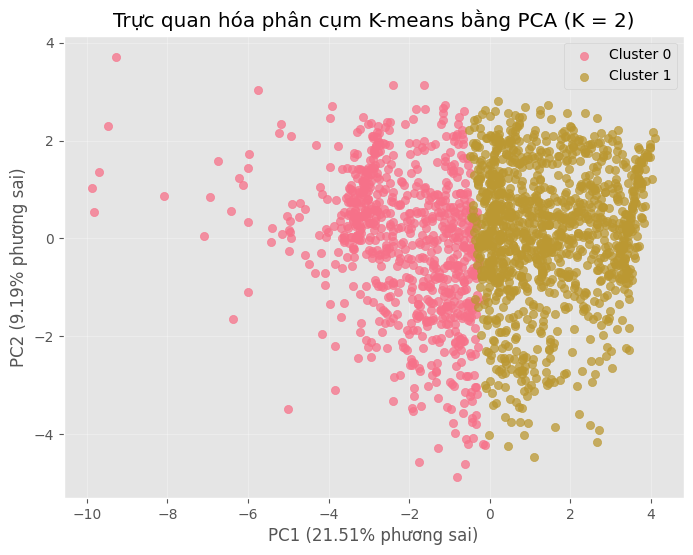

Trực quan hóa cụm bằng PCA.


In [40]:
plt.figure(figsize=(8, 6))

for c in range(optimal_k):
    mask = df_pca["Cluster"] == c
    plt.scatter(
        df_pca.loc[mask, "PC1"],
        df_pca.loc[mask, "PC2"],
        s=35,
        alpha=0.75,
        label=f"Cluster {c}"
    )

plt.title(f"Trực quan hóa phân cụm K-means bằng PCA (K = {optimal_k})")
plt.xlabel(f"PC1 ({explained_var[0]*100:.2f}% phương sai)")
plt.ylabel(f"PC2 ({explained_var[1]*100:.2f}% phương sai)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print("Trực quan hóa cụm bằng PCA.")

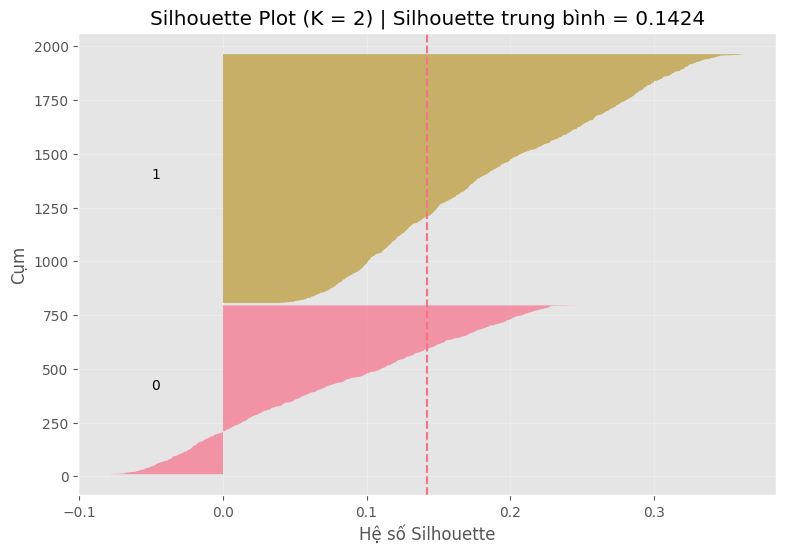

Silhouette Plot (Silhouette TB = 0.1424)


In [41]:
from sklearn.metrics import silhouette_samples, silhouette_score
import numpy as np

sil_avg = silhouette_score(X, clusters)
sil_values = silhouette_samples(X, clusters)

plt.figure(figsize=(9, 6))
y_lower = 10

for c in range(optimal_k):
    c_sil = sil_values[clusters == c]
    c_sil.sort()

    size_c = c_sil.shape[0]
    y_upper = y_lower + size_c

    plt.fill_betweenx(
        np.arange(y_lower, y_upper),
        0,
        c_sil,
        alpha=0.7
    )
    plt.text(-0.05, y_lower + 0.5 * size_c, str(c))
    y_lower = y_upper + 10

plt.axvline(x=sil_avg, linestyle="--")
plt.title(f"Silhouette Plot (K = {optimal_k}) | Silhouette trung bình = {sil_avg:.4f}")
plt.xlabel("Hệ số Silhouette")
plt.ylabel("Cụm")
plt.grid(True, alpha=0.25)
plt.show()

print(f"Silhouette Plot (Silhouette TB = {sil_avg:.4f})")

5.6. Giải thích các phân khúc sinh viên

Mục tiêu

Chuyển kết quả thuật toán thành ý nghĩa giáo dục thực tế

Trung bình các biến theo cụm

In [42]:
df_num_cluster = df_num.copy()
df_num_cluster["Cluster"] = clusters

cluster_mean = df_num_cluster.groupby("Cluster").mean()

print("Trung bình các biến theo cụm:")
display(cluster_mean.round(3))

Trung bình các biến theo cụm:


,Year,Gender,Policy_Stu,Minority_Stu,Poor_Stu,Father_Edu,Mother_Edu,Father_Occupation,Mother_Occupation,Time_Friends,...,GPA,Adapt_Learning_Uni,Study_Methods,SupportOf_Uni,SupportOf_Lec,Facilitie_Uni,Quality_Lecturer,TrainingCurriculum,Competitive_Class,InfuenceF_Friends
Cluster,,,,,,,,,,,,,,,,,,,,,
0,4.473,1.891,1.611,1.911,1.964,3.305,3.211,2.649,2.697,2.525,...,3.172,2.933,2.978,3.218,3.630,3.305,3.808,3.513,3.396,3.349
1,4.771,1.887,1.650,1.951,1.952,3.960,3.900,2.395,2.392,2.102,...,3.375,3.820,4.060,4.521,4.554,4.581,4.685,4.531,4.305,4.152


Chọn các biến phân biệt cụm rõ nhất

In [43]:
spread = (cluster_mean.max() - cluster_mean.min()).sort_values(ascending=False)

TOP_N = 6   # đủ dùng cho diễn giải
top_vars = spread.head(TOP_N).index.tolist()

print(f"{TOP_N} biến phân biệt cụm rõ nhất:")
display(spread.head(TOP_N).round(3))

print("Chân dung cụm (trên các biến quan trọng):")
display(cluster_mean[top_vars].round(3))

6 biến phân biệt cụm rõ nhất:


,0
SupportOf_Uni,1.303
Facilitie_Uni,1.276
Study_Methods,1.081
TrainingCurriculum,1.018
SupportOf_Lec,0.924
Competitive_Class,0.909


Chân dung cụm (trên các biến quan trọng):


,SupportOf_Uni,Facilitie_Uni,Study_Methods,TrainingCurriculum,SupportOf_Lec,Competitive_Class
Cluster,,,,,,
0,3.218,3.305,2.978,3.513,3.630,3.396
1,4.521,4.581,4.060,4.531,4.554,4.305


Điểm nổi bật từng cụm

In [44]:
overall_mean = df_num.mean()
diff = cluster_mean.subtract(overall_mean, axis=1)

for c in range(optimal_k):
    print(f"\n--- PHÂN KHÚC / CLUSTER {c} ---")

    top_high = diff.loc[c].sort_values(ascending=False).head(3)
    top_low  = diff.loc[c].sort_values(ascending=True).head(3)

    print("• Cao hơn trung bình:")
    display(top_high.round(3))

    print("• Thấp hơn trung bình:")
    display(top_low.round(3))


--- PHÂN KHÚC / CLUSTER 0 ---
• Cao hơn trung bình:


,0
Time_SocicalMedia,0.306
Time_Friends,0.252
Mother_Occupation,0.182


• Thấp hơn trung bình:


,0
SupportOf_Uni,-0.776
Facilitie_Uni,-0.760
Study_Methods,-0.644



--- PHÂN KHÚC / CLUSTER 1 ---
• Cao hơn trung bình:


,1
SupportOf_Uni,0.527
Facilitie_Uni,0.516
Study_Methods,0.437


• Thấp hơn trung bình:


,1
Time_SocicalMedia,-0.208
Time_Friends,-0.171
Mother_Occupation,-0.123
